# Convolutional Neural Network (CNN) for Fundus Image Classification (Baseline)
---

This Jupyter Notebook serves as the third installment in a series dedicated to the classification of Fundus images. While the first notebook focused on Exploratory Data Analysis (EDA) and the second delved into baseline models, this notebook specializes in employing Convolutional Neural Networks (CNNs) for the task.

## DISCLAMER
---
I will admit that this is a lot of spaghetti code and this was a playground to get used to the PyTorch framework and hash out what would work for the constrains of my system. 
<br> I used PyTorch to create our CNN. Initially I began using TensorFlow but this would not play nice with my system and no matter the enivronment setup, the GPU could not be mounted to speed up the training of the models and the CPU was taking far too long. 
<br> Setting up the envirionment in a Google Colab provided no better speed ups so it was decided to try our hand at PyTorch. 
<br> Working with an NVidia 1060 6GB with 16GB of ram lead to some issues in the pipeline such as restarting the kernel between every test because the VRAM would fill on the GPU. 
<br> The next notebook has been refactored and utilized a pretrained model. This greatly improved our memory efficiency and solved a lot of our training issues. 
---

#### Objectives
- Implement a CNN model from scratch for robust image classification.
- Train the model on a custom dataset of Fundus images, grouped into three categories: Normal (N), Diabetic Retinopathy (D), and Other Diseases (O).

#### Contents
- **Initial Setup**: Import all necessary libraries for data manipulation, visualization, and deep learning.
- **Data Loading**: Load the preprocessed Fundus images and their labels from train and test datasets.
- **Dataset Class**: Create a PyTorch `Dataset` subclass to manage image data and labels for training and validation.
- **Model Architecture**: Design a simple CNN architecture tailored for the classification task.
- **Model Training and Evaluation**: Employ techniques like early stopping based on validation loss to train the model efficiently.


### Initial Set Up

Importing all necessary libraries to be used in this notebook. 

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, accuracy_score

# Deep Learning with PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from torchvision.transforms import functional as F

# Image Processing
from PIL import Image

# OS Operations
import os

### Data Loading

We will load in the train and test .CSVs that were made in the previous notebooks. 

In [2]:
# Load train and test dataframes
train_df = pd.read_csv('data/train_df.csv')
test_df = pd.read_csv('data/test_df.csv')

### Defining A Dataset Class

Here we are going to be using PyTorch to create our CNN and the beginning of my spaghetti code. (The next notebook is better, I promise)

Here we define the dataset class

In [4]:
# Define Dataset Class
class FundusDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.df = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.label_mapping = {'D': 0, 'O': 1, 'N': 2}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.df.loc[idx, 'filename'])
        image = Image.open(img_name).convert('RGB')
        label_str = self.df.loc[idx, 'Grouped-Label']
        label = self.label_mapping[label_str]
        label = torch.tensor(label)

        if self.transform:
            image = self.transform(image)

        return image, label

Lets initialize some transform methods. The Resize method was played around with to try to fit the model within the memory constraints.
<br> Eventually it was found that restarting the kernel every time would alleviate some of these issues and the full 512x512 could be used. 

In [5]:
# Data Loading with transformation
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Images were resized multiple times to try to get them within the system constraints. 
    transforms.ToTensor()
])

Here we prepare the data to be loaded into the model. 
<br> A sample was done to try accomodate the memory issues along with retooling the batch size to try for some optimization. 

In [6]:
# Selecting a small subset (10 samples from each class) for demonstration
# small_train_df = train_df.groupby('Grouped-Label').apply(lambda x: x.sample((10)).reset_index(drop=True)
# train_dataset = FundusDataset(dataframe=small_train_df, root_dir='data/preprocessed_images', transform=transform)

#Loading the data into the model. 
train_dataset = FundusDataset(dataframe=train_df, root_dir='data/preprocessed_images', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=36, shuffle=True)  #The batch size was moved around the try to tune the model. 

Here the model is defined. 
<br>The `SimpleCNN` class defines a simple Convolutional Neural Network with the following architecture:

- **Conv1**: A convolutional layer with 3 input channels and 16 output channels, using a 3x3 kernel.
- **MaxPool**: Max pooling with a 2x2 window and stride of 2.
- **Conv2**: A second convolutional layer with 16 input channels and 32 output channels, also using a 3x3 kernel.
- **Fully Connected Layers**: 
  1. `fc1` with input size 32 * 126 * 126 and 128 output units.
  2. `fc2` with 128 input units and 3 output units (corresponding to the three classes: N, D, O).

The forward propagation (`forward` method) applies ReLU activation after each convolutional layer, followed by max pooling. The tensor is then flattened before passing through the fully connected layers, with ReLU activation applied before the final layer.

In [7]:
# Define Model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)  
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(32 * 126 * 126, 128)  
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))  
        x = self.pool(nn.functional.relu(self.conv2(x)))  
        x = x.view(-1, 32 * 126 * 126)  
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Here we initialize the model along with the device making sure it is using the GPU when possible. 
<br> The criterion is set to CrossEntropyLoss and an Adam optomizer was used with a learning rate of 0.001

In [8]:
# Initialize the model, loss, and optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Here we set some paramters for early stopping. 

In [9]:
# Additional code for early stopping
best_val_loss = float('inf')
patience_counter = 0
patience_limit = 5

A validation set was loaded using the training set. 

In [10]:
# Validation DataLoader
val_loader = DataLoader(train_dataset, batch_size=36, shuffle=False)

Here is the training loop. It is only running for two epochs because of the memory constraints. 

In [ ]:
# Training Loop (for 2 epochs as a demonstration)
for epoch in range(2):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        print(f"Epoch [{epoch+1}/2], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
    
        # Validation Loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Validation Loss: {val_loss:.4f}")

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience_limit:
            print("Early stopping.")
            break

print("Training complete.")

Epoch [1/2], Step [1/143], Loss: 1.1038


The above code snippets were adjusted and modified to be used below. 
<br> A more complex CNN was made with bach normalization and drop out to hopefully pull more information out of the images and yeild better results

### Model Architecture: OptimizedSimpleCNN

The `OptimizedSimpleCNN` class represents an optimized Convolutional Neural Network that builds upon `SimpleCNN` with additional layers and techniques for improved performance:

- **Conv1**: A convolutional layer with 3 input channels and 16 output channels, using a 3x3 kernel.
- **BatchNorm1**: Batch normalization applied to the output of `Conv1`.
- **MaxPool**: Max pooling with a 2x2 window and stride of 2.
- **Conv2**: A second convolutional layer with 16 input channels and 32 output channels, also using a 3x3 kernel.
- **BatchNorm2**: Batch normalization applied to the output of `Conv2`.
- **Fully Connected Layers**: 
  1. `fc1` with input size 32 * 126 * 126 and 128 output units.
  2. `Dropout`: A dropout layer with a rate of 0.5.
  3. `fc2` with 128 input units and 3 output units (corresponding to the three classes: N, D, O).

#### Forward Propagation
- Applies ReLU activation and batch normalization after each convolutional layer.
- Max pooling is applied post-activation.
- The tensor is flattened before passing through the fully connected layers.
- A dropout layer is included between the fully connected layers for regularization.

This optimized architecture aims to improve the model's performance with the inclusion of batch normalization and dropout layers.


In [3]:
# Define Dataset Class
class FundusDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.df = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.label_mapping = {'D': 0, 'O': 1, 'N': 2}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.df.loc[idx, 'filename'])
        image = Image.open(img_name).convert('RGB')
        label_str = self.df.loc[idx, 'Grouped-Label']
        label = self.label_mapping[label_str]
        label = torch.tensor(label)

        if self.transform:
            image = self.transform(image)

        return image, label

# Data Loading with transformation and small subset selection
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize images to 256x256
    transforms.ToTensor()
])

# Selecting a small subset (10 samples from each class) for demonstration
# small_train_df = train_df.groupby('Grouped-Label').apply(lambda x: x.sample((10)).reset_index(drop=True)
# train_dataset = FundusDataset(dataframe=small_train_df, root_dir='data/preprocessed_images', transform=transform)

train_dataset = FundusDataset(dataframe=train_df, root_dir='data/preprocessed_images', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)

# Define Model with Pooling Layers
class OptimizedSimpleCNN(nn.Module):
    def __init__(self):
        super(OptimizedSimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32 * 126 * 126, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.bn1(self.conv1(x))))
        x = self.pool(nn.functional.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 32 * 126 * 126)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x



# Initialize the model, loss, and optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = OptimizedSimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Additional code for early stopping
best_val_loss = float('inf')
patience_counter = 0
patience_limit = 5

# Validation DataLoader (for demonstration, using the same dataset as the training set)
val_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

# Training Loop (for 2 epochs as a demonstration)
for epoch in range(2):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        print(f"Epoch [{epoch+1}/2], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
    
    # Validation Loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    print(f"Validation Loss: {val_loss:.4f}")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience_limit:
        print("Early stopping.")
        break

print("Training complete.")

Epoch [1/2], Step [1/80], Loss: 1.0822
Epoch [1/2], Step [2/80], Loss: 137.4951
Epoch [1/2], Step [3/80], Loss: 143.9664
Epoch [1/2], Step [4/80], Loss: 193.5512
Epoch [1/2], Step [5/80], Loss: 138.2911
Epoch [1/2], Step [6/80], Loss: 78.9488
Epoch [1/2], Step [7/80], Loss: 75.7811
Epoch [1/2], Step [8/80], Loss: 77.3047
Epoch [1/2], Step [9/80], Loss: 53.9525
Epoch [1/2], Step [10/80], Loss: 44.6381
Epoch [1/2], Step [11/80], Loss: 37.6635
Epoch [1/2], Step [12/80], Loss: 20.2945
Epoch [1/2], Step [13/80], Loss: 18.6974
Epoch [1/2], Step [14/80], Loss: 12.4615
Epoch [1/2], Step [15/80], Loss: 9.0588
Epoch [1/2], Step [16/80], Loss: 3.3325
Epoch [1/2], Step [17/80], Loss: 2.3567
Epoch [1/2], Step [18/80], Loss: 1.8530
Epoch [1/2], Step [19/80], Loss: 3.0676
Epoch [1/2], Step [20/80], Loss: 1.0911
Epoch [1/2], Step [21/80], Loss: 1.0892
Epoch [1/2], Step [22/80], Loss: 1.0918
Epoch [1/2], Step [23/80], Loss: 1.1086
Epoch [1/2], Step [24/80], Loss: 1.0778
Epoch [1/2], Step [25/80], Loss:

KeyboardInterrupt: 

The above code was previously run and the results stored below. It was run again to give an idea of the training while not taking up the entire notebook. 

### Model Validation and Metrics Calculation

This code snippet performs the model validation and calculates key performance metrics. It initializes empty lists for storing true labels and predicted labels from the model.

#### Validation Loop
- **Torch No Grad**: Ensures that no gradients are calculated during this phase to save computational resources.
- **Model Eval**: Sets the model to evaluation mode to disable certain layers like dropout.
- **Iterating Through Data**: Iterates through each batch of images and labels using the training loader. For demonstration purposes, the training loader is used; however, in practice, a separate validation set should be used.
- **Predictions**: For each batch, predictions are generated by the model and both true and predicted labels are stored.

#### Metrics Calculation
- **F1 Score**: Weighted F1 score is calculated across all classes.
- **Recall**: Weighted recall is calculated across all classes.
- **Accuracy**: Overall accuracy is calculated.

After running this code, `f1`, `recall`, and `accuracy` variables will contain the respective metric values for evaluation.

In [4]:
# Initialize variables to store metrics
true_labels = []
predicted_labels = []

# Validation Loop
with torch.no_grad():
    model.eval()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate metrics
f1 = f1_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
accuracy = accuracy_score(true_labels, predicted_labels)

f1, recall, accuracy

(0.16269120928539874, 0.32876980246430665, 0.32876980246430665)

After running the validation loop, the key performance metrics for the model are as follows:

- **F1 Score**: 0.163
- **Recall**: 0.329
- **Accuracy**: 0.329

#### Observations
- The F1 Score, which is a balanced measure of precision and recall, is notably low. This indicates that the model is struggling to correctly classify the images.
- The Recall and Accuracy are also low, reinforcing the notion that the model's predictive capability is currently inadequate.

Given these metrics, further optimization and debugging are necessary to improve the model's performance.

### Data Augmentation and Transformation

Below transform the images to hopefully pull some more out of this model. 

Define the dataset class

In [3]:
# Define Dataset Class
class FundusDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.df = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.label_mapping = {'D': 0, 'O': 1, 'N': 2}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.df.loc[idx, 'filename'])
        image = Image.open(img_name).convert('RGB')
        label_str = self.df.loc[idx, 'Grouped-Label']
        label = self.label_mapping[label_str]
        label = torch.tensor(label)

        if self.transform:
            image = self.transform(image)

        return image, label

Here we will transform the images.

#### Training Transformations
- **Random Rotation**: Rotates the image by up to 5 degrees.
- **Color Jitter**: Randomly adjusts the brightness and contrast by a factor of 0.2.
- **Random Resized Crop**: Applies a random resized crop with scaling factors between 0.9 and 1.0, and aspect ratios between 0.9 and 1.1.
- **Resize**: Resizes all images to a uniform size of 512x512 pixels.
- **To Tensor**: Converts the PIL image to a PyTorch tensor.

#### Validation Transformations
- **Resize**: Resizes all images to 512x512 pixels.
- **To Tensor**: Converts the PIL image to a PyTorch tensor.

These transformations are encapsulated within `transform` and `val_transform` for training and validation datasets, respectively.


In [4]:
transform = transforms.Compose([
    transforms.RandomRotation(5),  # Small rotations
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness and contrast
    transforms.RandomResizedCrop(512, scale=(0.9, 1.0), ratio=(0.9, 1.1)),  # Slight scale and aspect ratio change
    transforms.Resize((512, 512)),  # Resize images to 512x512
    transforms.ToTensor(),
])

# Validation transform
val_transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize images to 512x512
    transforms.ToTensor(),
])

Lets take a look at some images in each class to get an idea of how the transformations performed.

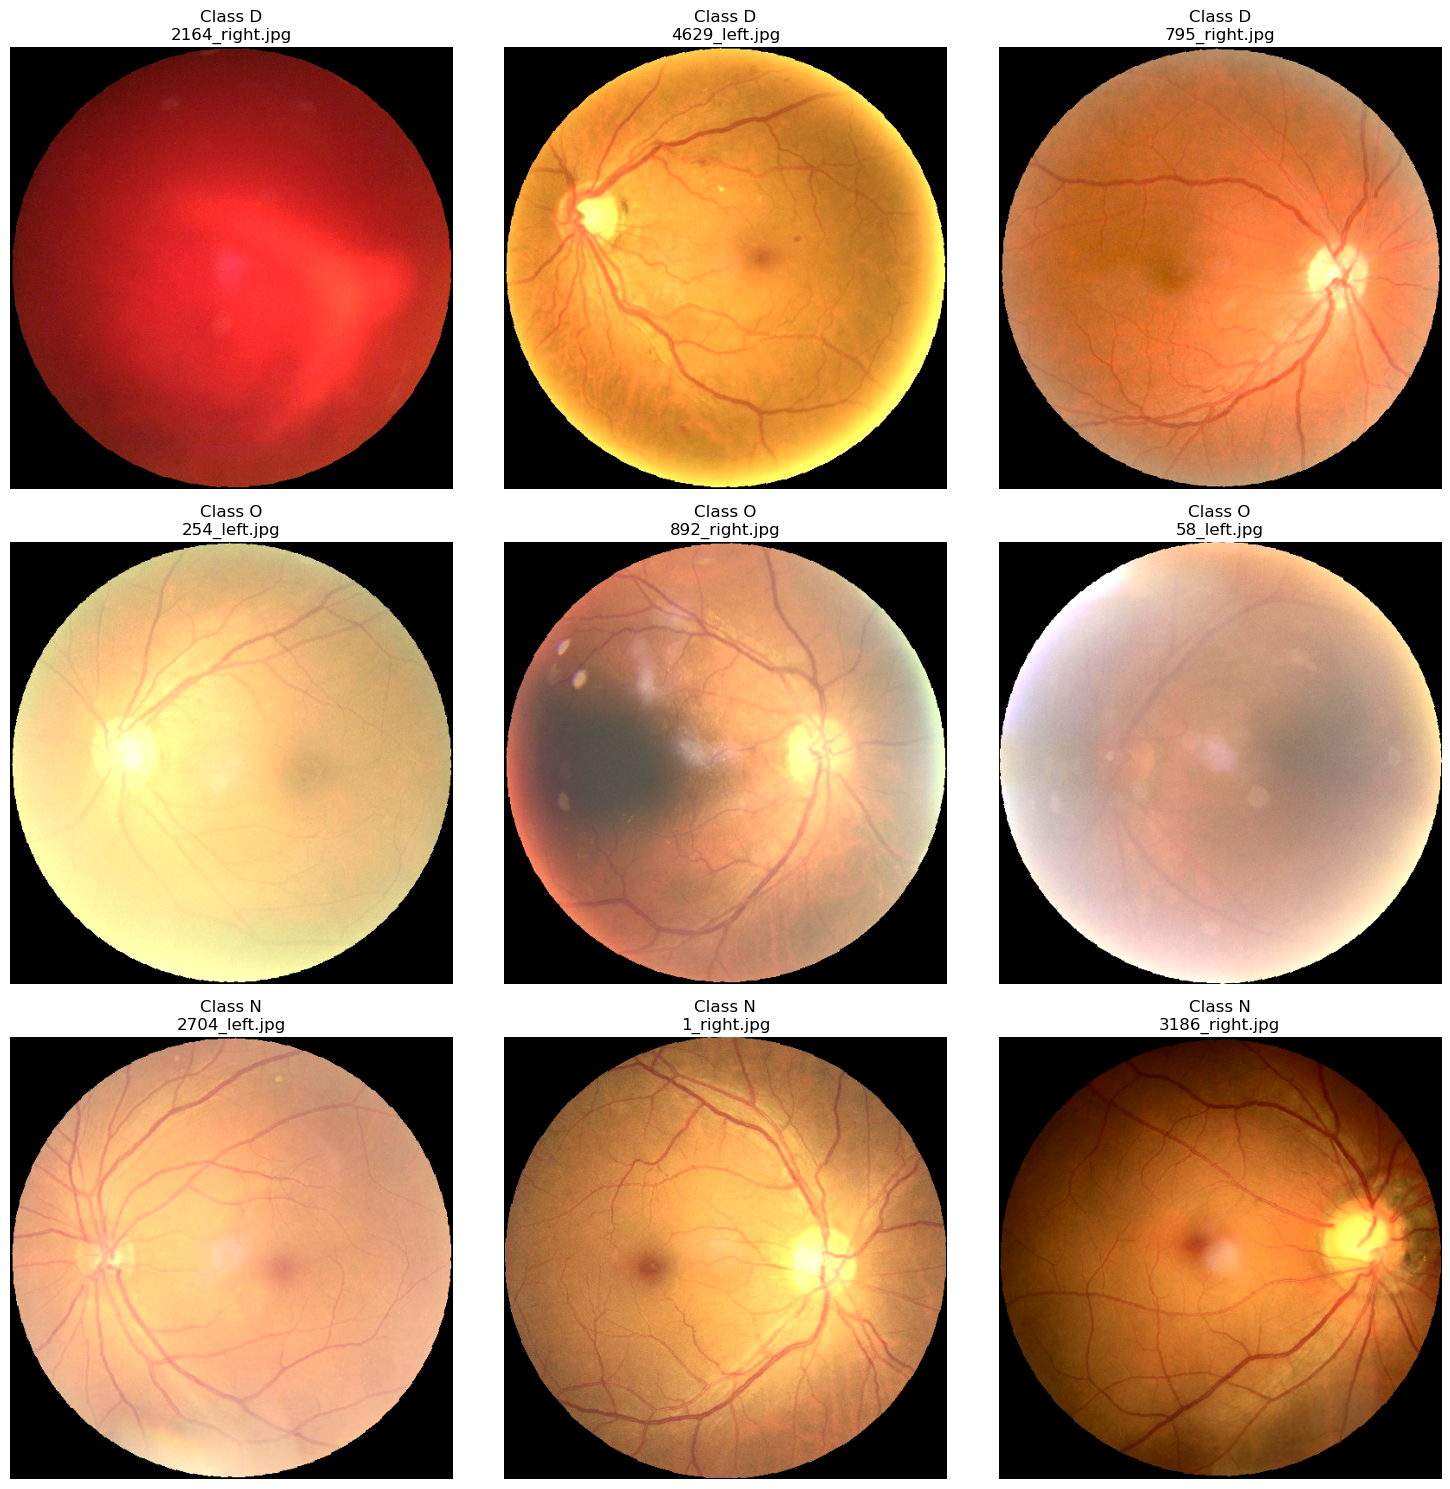

In [7]:
def show_transformed_images_by_label(df, transform, num_images=3):
    unique_labels = df['Grouped-Label'].unique()
    fig, axs = plt.subplots(nrows=len(unique_labels), ncols=num_images, figsize=(15, 5 * len(unique_labels)))

    for i, label in enumerate(unique_labels):
        # Filter dataframe by label and sample images
        sample_df = df[df['Grouped-Label'] == label].sample(num_images)
        for j, (_, row) in enumerate(sample_df.iterrows()):
            img_path = os.path.join('data/preprocessed_images', row['filename']) 
            image = Image.open(img_path).convert('RGB')
            if transform:
                image = transform(image)
            axs[i, j].imshow(image.permute(1, 2, 0))
            axs[i, j].set_title(f"Class {label}\n{row['filename']}")
            axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Show transformed images using the function
show_transformed_images_by_label(train_df, transform=transform, num_images=3)

Lets load up the model and see how it performs with the transformations. 

In [6]:
val_dataset = FundusDataset(dataframe=test_df, root_dir='data/preprocessed_images', transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Define Model with Pooling Layers
class OptimizedSimpleCNN(nn.Module):
    def __init__(self):
        super(OptimizedSimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32 * 126 * 126, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.bn1(self.conv1(x))))
        x = self.pool(nn.functional.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 32 * 126 * 126)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize the model, loss, and optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = OptimizedSimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Additional code for early stopping
best_val_loss = float('inf')
patience_counter = 0
patience_limit = 5


# Training Loop (for 2 epochs as a demonstration)
for epoch in range(2):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        print(f"Epoch [{epoch+1}/2], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
    
    # Validation Loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    print(f"Validation Loss: {val_loss:.4f}")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience_limit:
        print("Early stopping.")
        break

print("Training complete.")

Epoch [1/2], Step [1/80], Loss: 1.1305
Epoch [1/2], Step [2/80], Loss: 63.0145
Epoch [1/2], Step [3/80], Loss: 91.7426
Epoch [1/2], Step [4/80], Loss: 61.0702
Epoch [1/2], Step [5/80], Loss: 70.4103
Epoch [1/2], Step [6/80], Loss: 48.4332
Epoch [1/2], Step [7/80], Loss: 64.8473
Epoch [1/2], Step [8/80], Loss: 46.8931
Epoch [1/2], Step [9/80], Loss: 30.8188
Epoch [1/2], Step [10/80], Loss: 57.3897
Epoch [1/2], Step [11/80], Loss: 31.4432
Epoch [1/2], Step [12/80], Loss: 21.5648
Epoch [1/2], Step [13/80], Loss: 17.5600
Epoch [1/2], Step [14/80], Loss: 21.4490
Epoch [1/2], Step [15/80], Loss: 14.4362
Epoch [1/2], Step [16/80], Loss: 16.7502
Epoch [1/2], Step [17/80], Loss: 7.7785
Epoch [1/2], Step [18/80], Loss: 5.0106
Epoch [1/2], Step [19/80], Loss: 2.9660
Epoch [1/2], Step [20/80], Loss: 1.9446
Epoch [1/2], Step [21/80], Loss: 1.9381
Epoch [1/2], Step [22/80], Loss: 1.4664
Epoch [1/2], Step [23/80], Loss: 1.4823
Epoch [1/2], Step [24/80], Loss: 1.0886
Epoch [1/2], Step [25/80], Loss: 1

In [7]:
# Initialize variables to store metrics
true_labels = []
predicted_labels = []

# Validation Loop
with torch.no_grad():
    model.eval()  # Set the model to evaluation mode
    for images, labels in train_loader:  # Using train_loader for demonstration; in practice, use a separate validation set
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate metrics
f1 = f1_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
accuracy = accuracy_score(true_labels, predicted_labels)

f1, recall, accuracy

(0.1680920002678249, 0.3332681400352044, 0.3332681400352044)

After applying data augmentation and additional optimizations, the updated key performance metrics for the model are as follows:

- **F1 Score**: 0.168
- **Recall**: 0.333
- **Accuracy**: 0.333

#### Observations
- The F1 Score shows a modest improvement, but it is still significantly low, indicating that the model has room for improvement in both precision and recall.
- The Recall and Accuracy have also slightly improved but remain inadequate for a production setting.

Although there has been some progress, these metrics suggest that further tuning and optimization are still required to achieve a performant model.


Lets try some more data augmentation. 

Define the Dataset Class

In [3]:
# Define Dataset Class
class FundusDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.df = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.label_mapping = {'D': 0, 'O': 1, 'N': 2}  # Define label mapping here

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.df.loc[idx, 'filename'])
        image = Image.open(img_name).convert('RGB')
        label_str = self.df.loc[idx, 'Grouped-Label']
        label = self.label_mapping[label_str]  # Map label to integer
        label = torch.tensor(label)

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
# Data Loading with fixed transformation
transform = transforms.Compose([
    transforms.RandomRotation(5),  # Small rotations
    transforms.Lambda(lambda img: F.adjust_brightness(img, brightness_factor=1.2)),  # Fixed brightness
    transforms.Lambda(lambda img: F.adjust_contrast(img, contrast_factor=1.2)),  # Fixed contrast
    transforms.Resize((512, 512)),  # Resize images to 512x512
    transforms.ToTensor(),
])

# Validation transform
val_transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize images to 512x512
    transforms.ToTensor(),
])

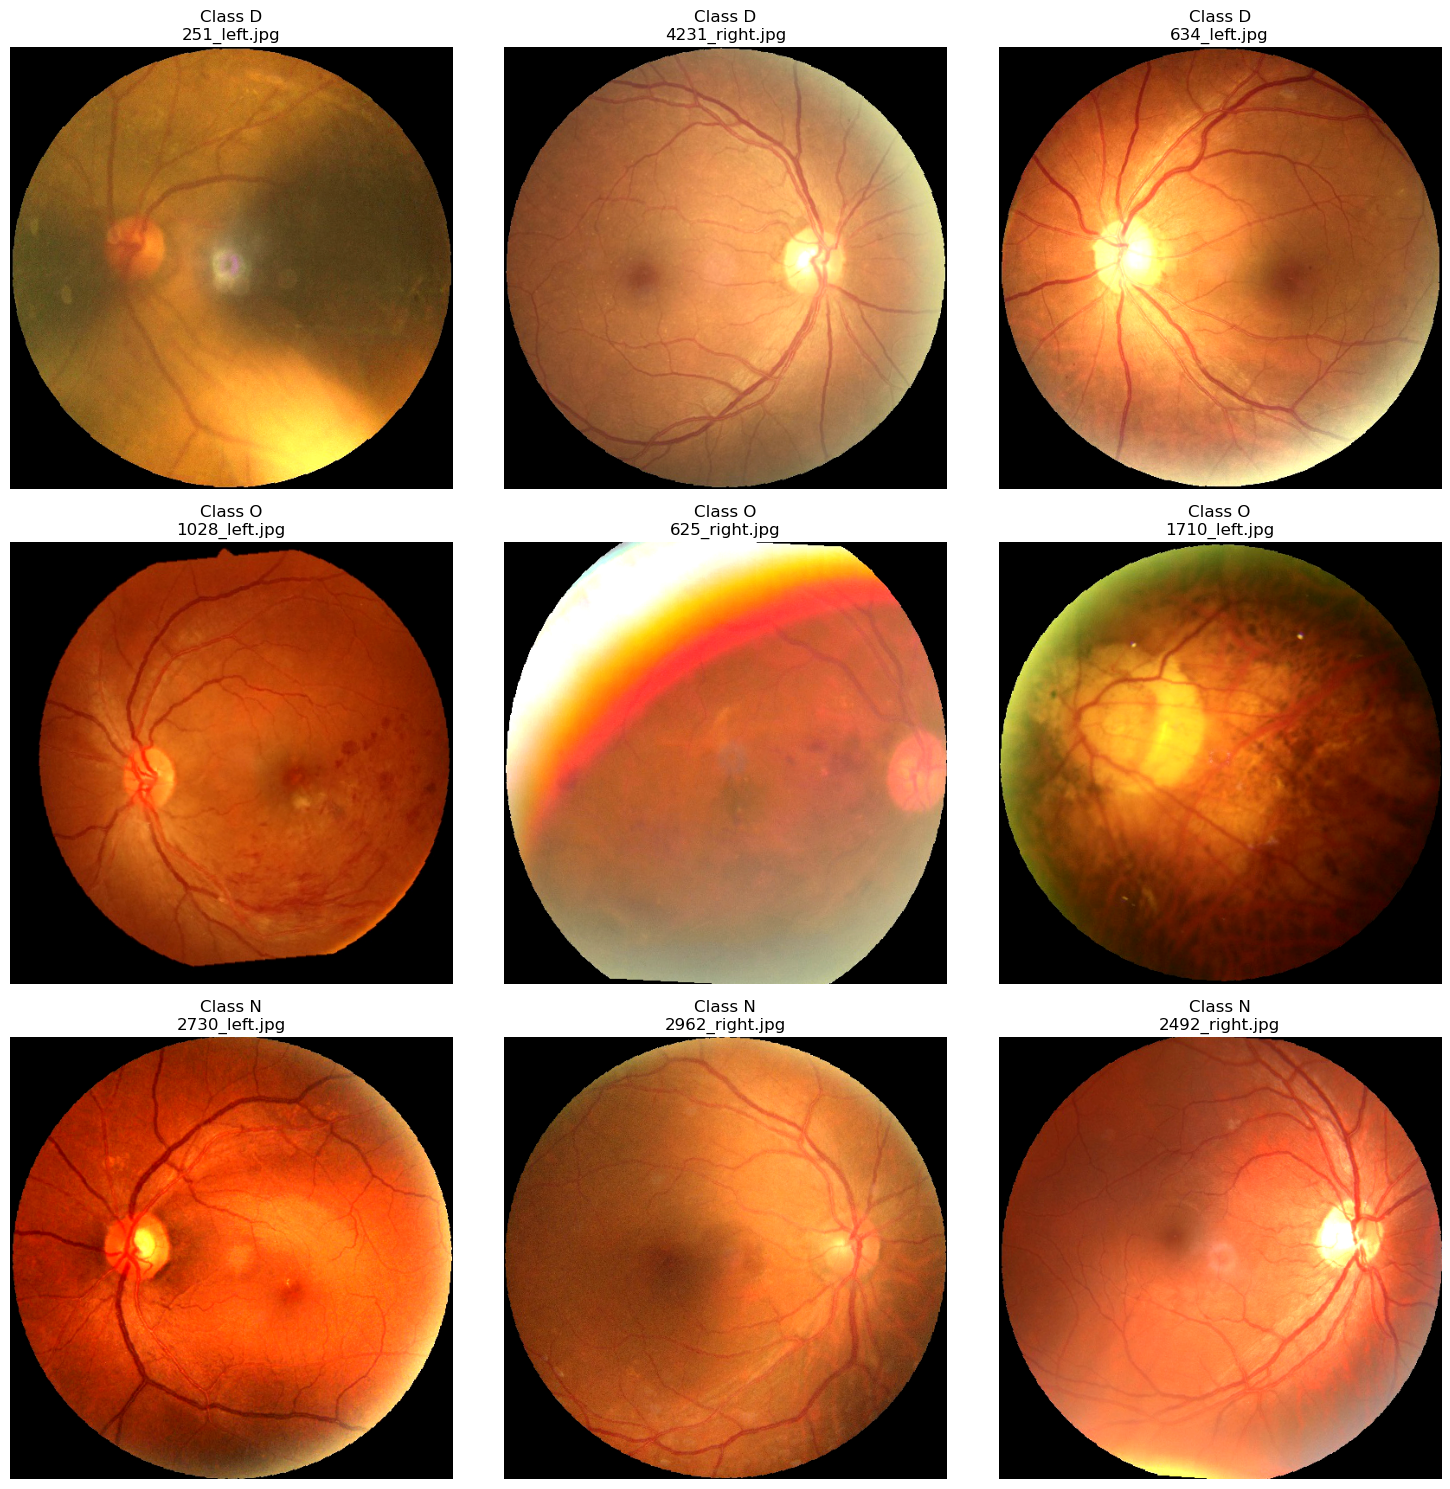

In [9]:
def show_transformed_images_by_label(df, transform, num_images=3):
    unique_labels = df['Grouped-Label'].unique()
    fig, axs = plt.subplots(nrows=len(unique_labels), ncols=num_images, figsize=(15, 5 * len(unique_labels)))

    for i, label in enumerate(unique_labels):
        # Filter dataframe by label and sample images
        sample_df = df[df['Grouped-Label'] == label].sample(num_images)
        for j, (_, row) in enumerate(sample_df.iterrows()):
            img_path = os.path.join('data/preprocessed_images', row['filename'])
            image = Image.open(img_path).convert('RGB')
            if transform:
                image = transform(image)
            axs[i, j].imshow(image.permute(1, 2, 0))
            axs[i, j].set_title(f"Class {label}\n{row['filename']}")  
            axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Show transformed images using the function
show_transformed_images_by_label(train_df, transform=transform, num_images=3)

Here we can see the images are brighter and the contrast is turned up. This will hopefully give some more information for the model to pick up and increase some of the accuracy. 

In [5]:
# Selecting a small subset (10 samples from each class) for demonstration
# small_train_df = train_df.groupby('Grouped-Label').apply(lambda x: x.sample((10)).reset_index(drop=True)
# train_dataset = FundusDataset(dataframe=small_train_df, root_dir='data/preprocessed_images', transform=transform)

train_dataset = FundusDataset(dataframe=train_df, root_dir='data/preprocessed_images', transform=transform)
val_dataset = FundusDataset(dataframe=test_df, root_dir='data/preprocessed_images', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define Model with Pooling Layers
class OptimizedSimpleCNN(nn.Module):
    def __init__(self):
        super(OptimizedSimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(1, 256)  # Placeholder size, will be updated dynamically
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 3)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.bn1(self.conv1(x))))
        x = self.pool(nn.functional.relu(self.bn2(self.conv2(x))))
        x = self.pool(nn.functional.relu(self.bn3(self.conv3(x))))
        x = self.dropout1(x)

        batch_size, num_channels, height, width = x.shape
        x = x.view(batch_size, -1) 

        # Update the input size of the first fully connected layer dynamically
        self.fc1 = nn.Linear(num_channels * height * width, 256)
        self.fc1 = self.fc1.to(device)  # Move the dynamically created layer to the GPU
        x = nn.functional.relu(self.fc1(x))

        x = self.dropout2(x)
        x = self.fc2(x)
        return x

# Initialize the model, loss, and optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = OptimizedSimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Additional code for early stopping
best_val_loss = float('inf')
patience_counter = 0
patience_limit = 5


# Training Loop (for 2 epochs as a demonstration)
for epoch in range(2):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        print(f"Epoch [{epoch+1}/2], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
    
    # Validation Loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    print(f"Validation Loss: {val_loss:.4f}")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience_limit:
        print("Early stopping.")
        break

print("Training complete.")

Epoch [1/2], Step [1/160], Loss: 1.1680
Epoch [1/2], Step [2/160], Loss: 1.1434
Epoch [1/2], Step [3/160], Loss: 1.1252
Epoch [1/2], Step [4/160], Loss: 1.0793
Epoch [1/2], Step [5/160], Loss: 1.1261
Epoch [1/2], Step [6/160], Loss: 1.1056
Epoch [1/2], Step [7/160], Loss: 1.1176
Epoch [1/2], Step [8/160], Loss: 1.1654
Epoch [1/2], Step [9/160], Loss: 1.1393
Epoch [1/2], Step [10/160], Loss: 1.1413
Epoch [1/2], Step [11/160], Loss: 1.1211
Epoch [1/2], Step [12/160], Loss: 1.1137
Epoch [1/2], Step [13/160], Loss: 1.0492
Epoch [1/2], Step [14/160], Loss: 1.0677
Epoch [1/2], Step [15/160], Loss: 1.1811
Epoch [1/2], Step [16/160], Loss: 1.1427
Epoch [1/2], Step [17/160], Loss: 1.1622
Epoch [1/2], Step [18/160], Loss: 1.1204
Epoch [1/2], Step [19/160], Loss: 1.0841
Epoch [1/2], Step [20/160], Loss: 1.0978
Epoch [1/2], Step [21/160], Loss: 1.0979
Epoch [1/2], Step [22/160], Loss: 1.0956
Epoch [1/2], Step [23/160], Loss: 1.1306
Epoch [1/2], Step [24/160], Loss: 1.1214
Epoch [1/2], Step [25/160

In [6]:
# Initialize variables to store metrics
true_labels = []
predicted_labels = []

# Validation Loop
with torch.no_grad():
    model.eval()  # Set the model to evaluation mode
    for images, labels in train_loader:  # Using train_loader for demonstration; in practice, use a separate validation set
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate metrics
f1 = f1_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
accuracy = accuracy_score(true_labels, predicted_labels)

f1, recall, accuracy

(0.32462509748565355, 0.3344416194015255, 0.3344416194015255)

### Comparison of Model Performance Metrics

#### Augmented Baseline CNN Model
- **F1 Score**: 0.325
- **Recall**: 0.334
- **Accuracy**: 0.334

#### Initial Baseline CNN Model
- **F1 Score**: 0.168
- **Recall**: 0.333
- **Accuracy**: 0.333

#### Observations
- The F1 Score sees a notable increase from 0.168 to 0.325, indicating improvements in both precision and recall.
- Recall and Accuracy are fairly stable, showing a slight increase from 0.333 to 0.334.

The metrics indicate that the augmented baseline CNN model performs better than the initial one, particularly in terms of F1 Score. This suggests that the changes made between these two models have contributed to a more balanced and improved classification performance.